The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [14]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps --force-reinstall
!pip install numpy>=1.20

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-exh650tg
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-exh650tg
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=44d6e0ecc58cb0e19c1da691edc7697d382e87ef652a7292500732ec7b8f6bda
  Stored in directory: /tmp/pip-ephem-wheel-cache-p_7_n3vw/wheels/3e/87/36/53b013ece7da539a59fcc56da2d329d7afb08eef9a9a5ae1d1
Successfully built d2l
  Attempting uninstall: d2l
    Found existing installation: d2l 2.0.0
    Uninstalling d2l-2.0.0:
      Successfully uni

^C


#  序列到序列学习（seq2seq）
:label:`sec_seq2seq`

正如我们在 :numref:`sec_machine_translation`中看到的，
机器翻译中的输入序列和输出序列都是长度可变的。
为了解决这类问题，我们在 :numref:`sec_encoder-decoder`中
设计了一个通用的”编码器－解码器“架构。
本节，我们将使用两个循环神经网络的编码器和解码器，
并将其应用于*序列到序列*（sequence to sequence，seq2seq）类的学习任务
 :cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014`。

遵循编码器－解码器架构的设计原则，
循环神经网络编码器使用长度可变的序列作为输入，
将其转换为固定形状的隐状态。
换言之，输入序列的信息被*编码*到循环神经网络编码器的隐状态中。
为了连续生成输出序列的词元，
独立的循环神经网络解码器是基于输入序列的编码信息
和输出序列已经看见的或者生成的词元来预测下一个词元。
 :numref:`fig_seq2seq`演示了
如何在机器翻译中使用两个循环神经网络进行序列到序列学习。

![使用循环神经网络编码器和循环神经网络解码器的序列到序列学习](http://d2l.ai/_images/seq2seq.svg)
:label:`fig_seq2seq`

在 :numref:`fig_seq2seq`中，
特定的“&lt;eos&gt;”表示序列结束词元。
一旦输出序列生成此词元，模型就会停止预测。
在循环神经网络解码器的初始化时间步，有两个特定的设计决定：
首先，特定的“&lt;bos&gt;”表示序列开始词元，它是解码器的输入序列的第一个词元。
其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。
例如，在 :cite:`Sutskever.Vinyals.Le.2014`的设计中，
正是基于这种设计将输入序列的编码信息送入到解码器中来生成输出序列的。
在其他一些设计中 :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`，
如 :numref:`fig_seq2seq`所示，
编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分。
类似于 :numref:`sec_language_model`中语言模型的训练，
可以允许标签成为原始的输出序列，
从源序列词元“&lt;bos&gt;”“Ils”“regardent”“.”
到新序列词元
“Ils”“regardent”“.”“&lt;eos&gt;”来移动预测的位置。

下面，我们动手构建 :numref:`fig_seq2seq`的设计，
并将基于 :numref:`sec_machine_translation`中
介绍的“英－法”数据集来训练这个机器翻译模型。


In [16]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## 编码器

从技术上讲，编码器将长度可变的输入序列转换成
形状固定的上下文变量$\mathbf{c}$，
并且将输入序列的信息在该上下文变量中进行编码。
如 :numref:`fig_seq2seq`所示，可以使用循环神经网络来设计编码器。

考虑由一个序列组成的样本（批量大小是$1$）。
假设输入序列是$x_1, \ldots, x_T$，
其中$x_t$是输入文本序列中的第$t$个词元。
在时间步$t$，循环神经网络将词元$x_t$的输入特征向量
$\mathbf{x}_t$和$\mathbf{h} _{t-1}$（即上一时间步的隐状态）
转换为$\mathbf{h}_t$（即当前步的隐状态）。
使用一个函数$f$来描述循环神经网络的循环层所做的变换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

总之，编码器通过选定的函数$q$，
将所有时间步的隐状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

比如，当选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$时
（就像 :numref:`fig_seq2seq`中一样），
上下文变量仅仅是输入序列在最后时间步的隐状态$\mathbf{h}_T$。

到目前为止，我们使用的是一个单向循环神经网络来设计编码器，
其中隐状态只依赖于输入子序列，
这个子序列是由输入序列的开始位置到隐状态所在的时间步的位置
（包括隐状态所在的时间步）组成。
我们也可以使用双向循环神经网络构造编码器，
其中隐状态依赖于两个输入子序列，
两个子序列是由隐状态所在的时间步的位置之前的序列和之后的序列
（包括隐状态所在的时间步），
因此隐状态对整个序列的信息都进行了编码。

现在，让我们[**实现循环神经网络编码器**]。
注意，我们使用了*嵌入层*（embedding layer）
来获得输入序列中每个词元的特征向量。
嵌入层的权重是一个矩阵，
其行数等于输入词表的大小（`vocab_size`），
其列数等于特征向量的维度（`embed_size`）。
对于任意输入词元的索引$i$，
嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其特征向量。
另外，本文选择了一个多层门控循环单元来实现编码器。


In [17]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        #这里输出是(num_steps，batch_sizeembed_size)
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens) 我知道一维度的state输出就是batchsize num_hiddens
        return output, state

In [6]:
import torch
import torch.nn as nn

# 参数设置
vocab_size = 5
embed_size = 3
batch_size = 2
seq_len = 4

# 创建相同的随机嵌入矩阵
torch.manual_seed(42)  # 确保可重复
embedding_layer = nn.Embedding(vocab_size, embed_size)

# 创建随机输入
indices = torch.randint(0, vocab_size, (batch_size, seq_len))
print("输入索引:")
print(indices)
'''
输入索引:
tensor([[0, 4, 3, 4],
        [4, 1, 2, 0]])
2,4
'''

# 方法1: 使用 nn.Embedding（高效方法）
efficient_result = embedding_layer(indices)
'''
（2，4，3）
'''
print("\n直接索引查找结果:")
print(efficient_result)

# 方法2: 使用 one-hot + 矩阵乘法（低效方法）
def one_hot_embedding(indices, embedding_matrix):
    # 创建 one-hot 编码
    one_hot = torch.zeros(indices.shape[0], indices.shape[1], vocab_size) #2*4*5 2句话 4个单词 每个单词对应vocab 为5
    one_hot.scatter_(2, indices.unsqueeze(2), 1)#在第二个维度 利用1 给2,4索引 给插入1
    '''
    tensor([[0, 4, 3, 4],
        [4, 1, 2, 0]])
    indices.unsqueeze(2)
    这就是（2，4）扩展到（2，4，1）
    '''

    # 矩阵乘法
    return torch.matmul(one_hot, embedding_matrix)

inefficient_result = one_hot_embedding(indices, embedding_layer.weight)
print("\nOne-hot + 矩阵乘法结果:")
print(inefficient_result)

# 验证两种方法结果相同
print("\n两种方法结果是否相同:", torch.allclose(efficient_result, inefficient_result))

输入索引:
tensor([[0, 4, 3, 4],
        [4, 1, 2, 0]])

直接索引查找结果:
tensor([[[ 0.3367,  0.1288,  0.2345],
         [ 1.1103, -1.6898, -0.9890],
         [ 0.2674,  0.5349,  0.8094],
         [ 1.1103, -1.6898, -0.9890]],

        [[ 1.1103, -1.6898, -0.9890],
         [ 0.2303, -1.1229, -0.1863],
         [ 2.2082, -0.6380,  0.4617],
         [ 0.3367,  0.1288,  0.2345]]], grad_fn=<EmbeddingBackward0>)

One-hot + 矩阵乘法结果:
tensor([[[ 0.3367,  0.1288,  0.2345],
         [ 1.1103, -1.6898, -0.9890],
         [ 0.2674,  0.5349,  0.8094],
         [ 1.1103, -1.6898, -0.9890]],

        [[ 1.1103, -1.6898, -0.9890],
         [ 0.2303, -1.1229, -0.1863],
         [ 2.2082, -0.6380,  0.4617],
         [ 0.3367,  0.1288,  0.2345]]], grad_fn=<UnsafeViewBackward0>)

两种方法结果是否相同: True


​执行 scatter_ 操作​：\\\
one_hot.scatter_(2, indices.unsqueeze(2), 1)表示：\\\
dim=2：沿着第2维（即 vocab_size维度）进行散布操作。\\\
index=indices.unsqueeze(2)：使用处理后的索引张量（形状 [2, 4, 1]）来指定位置。\\\
src=1：将值1填充到指定的位置。\\\
对于每个批次和每个时间步，index中的值指定了在 vocab_size维度上的索引位置，并将该位置设置为1。\\\
例如：\\\
对于第一个样本的第一个时间步，index[0,0,0]=0，所以将 one_hot[0,0,0]设置为1。\\\
对于第一个样本的第二个时间步，index[0,1,0]=4，所以将 one_hot[0,1,4]设置为1。\\\
以此类推。



In [2]:
import torch

# 假设词汇表大小为4000
vocab_size = 4000

# 假设单词索引（根据您的词汇表）
word_indices = {
    "this": 300,
    "is": 100,
    "a": 0,
    "new": 200,
    "world": 400
}

# 句子单词序列
sentence = ["this", "is", "a", "new", "world"]
indices = [word_indices[word] for word in sentence]  # 得到索引列表: [300, 100, 0, 200, 400]

# 将索引转换为张量
indices_tensor = torch.tensor(indices)  # 形状: [5]

# 创建 one-hot 编码
one_hot = torch.zeros(len(sentence), vocab_size)  # 创建5x4000的零矩阵
one_hot.scatter_(1, indices_tensor.unsqueeze(1), 1)  # 在对应索引位置填充1。第二个1:index=indices_tensor.unsqueeze(1)：索引张量，形状需要匹配。
#通过 unsqueeze(1)扩展维度得到，形状变为 [5, 1]。它提供了每个单词在 dim=1维度上的目标列索引。

print(one_hot.shape)  # 输出: torch.Size([5, 4000])
print(one_hot)

torch.Size([5, 4000])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


循环层返回变量的说明可以参考 :numref:`sec_rnn-concise`。

下面，我们实例化[**上述编码器的实现**]：
我们使用一个两层门控循环单元编码器，其隐藏单元数为$16$。
给定一小批量的输入序列`X`（批量大小为$4$，时间步为$7$）。
在完成所有时间步后，
最后一层的隐状态的输出是一个张量（`output`由编码器的循环层返回），
其形状为（时间步数，批量大小，隐藏单元数）。


In [5]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

由于这里使用的是门控循环单元，
所以在最后一个时间步的多层隐状态的形状是
（隐藏层的数量，批量大小，隐藏单元的数量）。
如果使用长短期记忆网络，`state`中还将包含记忆单元信息。


In [6]:
state.shape

torch.Size([2, 4, 16])

## [**解码器**]
:label:`sec_seq2seq_decoder`

正如上文提到的，编码器输出的上下文变量$\mathbf{c}$
对整个输入序列$x_1, \ldots, x_T$进行编码。
来自训练数据集的输出序列$y_1, y_2, \ldots, y_{T'}$，
对于每个时间步$t'$（与输入序列或编码器的时间步$t$不同），
解码器输出$y_{t'}$的概率取决于先前的输出子序列
$y_1, \ldots, y_{t'-1}$和上下文变量$\mathbf{c}$，
即$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。

为了在序列上模型化这种条件概率，
我们可以使用另一个循环神经网络作为解码器。
在输出序列上的任意时间步$t^\prime$，
循环神经网络将来自上一时间步的输出$y_{t^\prime-1}$
和上下文变量$\mathbf{c}$作为其输入，
然后在当前时间步将它们和上一隐状态
$\mathbf{s}_{t^\prime-1}$转换为
隐状态$\mathbf{s}_{t^\prime}$。
因此，可以使用函数$g$来表示解码器的隐藏层的变换：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

在获得解码器的隐状态之后，
我们可以使用输出层和softmax操作
来计算在时间步$t^\prime$时输出$y_{t^\prime}$的条件概率分布
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$。

根据 :numref:`fig_seq2seq`，当实现解码器时，
我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。
这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。
为了进一步包含经过编码的输入序列的信息，
上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。
为了预测输出词元的概率分布，
在循环神经网络解码器的最后一层使用全连接层来变换隐状态。


In [28]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        #这里输出是(num_steps，batch_sizeembed_size)
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens) 我知道一维度的state输出就是batchsize num_hiddens
        return output, state

In [29]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps

        # 在代码中添加调试语句
        '''
        print("state类型:", type(state))
        print("state形状:", state.shape if hasattr(state, 'shape') else "元组")
        if isinstance(state, tuple):
            print("state长度:", len(state))
            for i, s in enumerate(state):
                print(f"state[{i}]形状:", s.shape)
        '''
        context = state[-1].repeat(X.shape[0], 1, 1)
        #这里把最后一个state的(batch_size, num_hiddens) 然后进行不断的repeat到x.shape形式
        #最后一层状态被认为是最抽象、最全局的表示，它包含了整个输入序列的压缩信息。
        '''
        state: num_layers batchsize num_hiddens.
        state[-1]:num_hiddens 这个意思是在num_hiddens处 然后
        X.shape[0]:num_layers
        state = (hidden_states,)  # 这是一个单元素元组
        # hidden_states 的形状： [num_layers, batch_size, num_hiddens]
        state = (
                tensor([num_layers, batch_size, num_hiddens])  # 单个张量包含所有层
                )
        # 要获取特定层，需要在张量上索引：
        last_layer = state[-1][-1]  # 形状: [batch_size, num_hiddens]
        first_layer = state[-1][0]   # 形状: [batch_size, num_hiddens]
        '''
        #
        X_and_context = torch.cat((X, context), 2) #x:
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

在训练良好的RNN中：\\\
高层状态已经包含了低层状态的精华信息\\\
低层状态包含的细节信息对解码可能不是必需的\\\
添加低层信息可能引入噪声而非有用信号\\\

下面，我们用与前面提到的编码器中相同的超参数来[**实例化解码器**]。
如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小），
其中张量的最后一个维度存储预测的词元分布。


In [11]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

state类型: <class 'torch.Tensor'>
state形状: torch.Size([2, 4, 16])


(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

总之，上述循环神经网络“编码器－解码器”模型中的各层如
 :numref:`fig_seq2seq_details`所示。

![循环神经网络编码器-解码器模型中的层](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/seq2seq-details.svg?raw=1)
:label:`fig_seq2seq_details`

## 损失函数

在每个时间步，解码器预测了输出词元的概率分布。
类似于语言模型，可以使用softmax来获得分布，
并通过计算交叉熵损失函数来进行优化。
回想一下 :numref:`sec_machine_translation`中，
特定的填充词元被添加到序列的末尾，
因此不同长度的序列可以以相同形状的小批量加载。
但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的`sequence_mask`函数
[**通过零值化屏蔽不相关的项**]，
以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。
例如，如果两个序列的有效长度（不包括填充词元）分别为$1$和$2$，
则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。


In [11]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [13]:
# 原始序列（不同长度）
'''
valid_len = torch.tensor([1, 2])表示：
序列1的有效长度 = 1（只有第一个词是真实的）
序列2的有效长度 = 2（前两个词是真实的）

'''
seq1 = ["hello"]          # 长度1
seq2 = ["I", "love"]      # 长度2

# 填充到相同长度 2*3
X_padded = [[1, 0, 0],    # "hello" + 填充
            [4, 5, 0]]    # "I love" + 填充

# 使用掩码忽略填充位置 X_padded一般就是取
X_masked = sequence_mask(X_padded, torch.tensor([1, 2]))#这个值决定了X中第几行哪个是前几个是真实的。

AttributeError: 'list' object has no attribute 'size'

In [ ]:
#mask的解释：
import torch

# 假设 valid_len = [3, 5, 2] (3个序列的实际长度)
valid_len = torch.tensor([3, 5, 2])
maxlen = 5

# 创建位置索引
positions = torch.tensor([1, 2, 3])[None, :]  # 形状: [1, 3]
#positions[None, :]形状: [1, 3]
#[[1, 2, 3]]
#valid_len[:, None]形状: [3, 1]
'''
[[3],
 [5],
 [2]]
'''
#2. 广播比较过程
通过广播机制，这两个张量会扩展为：
位置张量扩展:      [[1, 2, 3],
                   [1, 2, 3],
                   [1, 2, 3]]

有效长度张量扩展:  [[3, 3, 3],
                   [5, 5, 5],
                   [2, 2, 2]]

[[1<3, 2<3, 3<3],
 [1<5, 2<5, 3<5],
 [1<2, 2<2, 3<2]]
tensor([[ True,  True, False],   # 第1个序列：位置1,2有效，3无效
        [ True,  True,  True],   # 第2个序列：所有位置有效
        [ True, False, False]])  # 第3个序列：只有位置1有效


(**我们还可以使用此函数屏蔽最后几个轴上的所有项。**)如果愿意，也可以使用指定的非零值来替换这些项。


In [30]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    '''
    X.size(1)返回第1维大小：3（列数）
    torch.arange((maxlen), dtype=torch.float32,device=X.device): [0 1 2] 形状: [3]  [None, :]: [1,3]
    [1, 2] shape为2 valid_len[:, None]： [2,1]
    [1,3]变成[2,3] [[0,1,2] [0,1,2]]
    [2,1]变成[2,3] [[1 1 1][2 2 2]]
    [[1,2,3] [1,2,3]] < [[1 1 1][2 2 2]]
    [[False,  True,  True],
    [False, False,  True]]这是(2,3)
    '''

    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]

    X[~mask] = value #~mask 取反
    return X
X = torch.ones(2, 3, 4)
#最终还是把valid_len给扩展到和X一样的维度，然后做好判断。valid length的个数是batch size
#X：(batch_size,num_steps,vocab_size) batch size=2就是2句话 num_steps每句话有num_steps个单词
#然后val_len: torch.tensor([1, 2]) 这里就是每句话前几个单词是有用的
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [ ]:
原始掩码 (~mask):
[[False,  True,  True],
 [False, False,  True]]  形状: [2, 3]

广播后掩码:
[[[False, False, False, False],  # 第0行第0列扩展
  [ True,  True,  True,  True],   # 第0行第1列扩展
  [ True,  True,  True,  True]],  # 第0行第2列扩展

 [[False, False, False, False],  # 第1行第0列扩展
  [False, False, False, False],  # 第1行第1列扩展
  [ True,  True,  True,  True]]] # 第1行第2列扩展
形状: [2, 3, 4] 我不明白为啥扩展后是这样样子
具体怎么扩展：
mask_2d = torch.tensor([[False,  True,  True],
[False, False,  True]])  # 形状: [2, 3]
mask_3d = mask_2d.unsqueeze(2)  # 形状: [2, 3, 1]
tensor([[[False],
     [ True],
     [ True]],

     [[False],
     [False],
     [ True]]])
扩展后：
tensor([[[False, False, False, False],
    [ True,  True,  True,  True],
    [ True,  True,  True,  True]],

    [[False, False, False, False],
    [False, False, False, False],
    [ True,  True,  True,  True]]])

现在，我们可以[**通过扩展softmax交叉熵损失函数来遮蔽不相关的预测**]。
最初，所有预测词元的掩码都设置为1。
一旦给定了有效长度，与填充词元对应的掩码将被设置为0。
最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。


In [31]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps) 每句话每个单词给一个label来做ground truth
    # label形状: (2, 3)(2个句子，每句3个真实词索引)
    # valid_len的形状：(batch_size,) 有效长度
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)#生成了个两维度的权重 都是1
        weights = sequence_mask(weights, valid_len) #这里的weights就是X 这里需要输入
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward( #super：调用父类
            pred.permute(0, 2, 1), label)
        '''
        pred的形状：(batch_size,num_steps,vocab_size)#每句话 每个单词 在vocab_size上给对应的概率。
        经过pred.permute(0, 2, 1): #这里是每句话。每个单词在vocab size上对应的概率 ， 对应的单词。
        取值的话就是 句子 0 单词 0 概率[五个概率] 找到这个单词对应的label 所在的vocab 的概率。
        pred的形状：(batch_size,vocab_size,num_steps)
        label的形状：(batch_size,num_steps)

        ​input(预测值)​​： 要求形状为 (batch_size, num_classes, ...)，
        即类别维度（通常是词汇表大小 vocab_size）必须在第 1 维（从 0 开始算）​
        '''
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        #沿序列维度求平均 (masked_loss.mean(dim=1)) 每句话一个loss
        #unweighted_loss （2，3）
        #
        return weighted_loss

我们可以创建三个相同的序列来进行[**代码健全性检查**]，
然后分别指定这些序列的有效长度为$4$、$2$和$0$。
结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。


In [26]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0])) #形状 (batch_size,)​：这表示一个一维张量（1D Tensor）​，或者通俗地说，是一个向量（Vector）

tensor([2.3026, 1.1513, 0.0000])

​对于第一个句子的第一个词 (位置 [0,0])​:  
取出 pred.permute(0,2,1)[0, :, 0]-> 形状 (5,)，这是第一个句子第一个词在所有5个词.  汇上的分数     
取出 label[0, 0]-> 一个标量，比如 3，表示正确词是词汇表中的第3个词。    
计算 -log(softmax(分数))，但只取第3个词对应的损失值   
结果 loss_00是一个标量。    
对所有位置重复此操作​：   
[0,1]-> loss_01   
[0,2]-> loss_02   
[1,0]-> loss_10   
[1,1]-> loss_11   
[1,2]-> loss_12   
unweighted_loss = [   
    [loss_00, loss_01, loss_02],  # 第一个句子的3个位置损失   
    [loss_10, loss_11, loss_12]   # 第二个句子的3个位置损失   
]  
最后得到的是每个句子的loss


## [**训练**]
:label:`sec_seq2seq_training`

在下面的循环训练过程中，如 :numref:`fig_seq2seq`所示，
特定的序列开始词元（“&lt;bos&gt;”）和
原始的输出序列（不包括序列结束词元“&lt;eos&gt;”）
拼接在一起作为解码器的输入。
这被称为*强制教学*（teacher forcing），
因为原始的输出序列（词元的标签）被送入解码器。
或者，将来自上一个时间步的*预测*得到的词元作为解码器的当前输入。


In [32]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            #batch里面的X 存着 X, X_valid_len, Y, Y_valid_len？四个变量？
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], #<bos>（Beginning Of Sequence） token。
                          device=device).reshape(-1, 1)
            '''
            [tgt_vocab['<bos>']] * Y.shape[0]: 创建一个列表，
            包含batch_size个相同的<bos>索引。Y.shape[0]就是批次大小batch_size。
            '''
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()	# 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

动作一：准备完美输入（你正在问的这行代码）​​\\\
​目的​：确保解码器在每个时间步的输入都是真实答案（Ground Truth）​，而不是它自己上一步的\\\预测。
​方法​：构造 dec_input，其值为 [<bos>, Y1, Y2, ..., Y_{n-1}]。这就是那张“标准字帖”。\\\
​<bos>的作用​：只是一个起始信号，告诉解码器：“开始生成序列了！这是第一个词的上下文。” 没有它，解码器就没有开始的依据。\\\

In [ ]:
  #bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], #<bos>（Beginning Of Sequence） token。
   #                       device=device).reshape(-1, 1) 例子：
tgt_vocab = {'<pad>': 0, '<bos>': 1, '<eos>': 2, 'hello': 3, 'world': 4}
# 这意味着 <bos> 的索引是 1
Y = torch.tensor([[3, 4, 2, 0],  # 序列1: "hello world <eos> <pad>"
                  [1, 3, 2, 0],  # 序列2: "<bos> hello <eos> <pad>" (可能是一个错误序列，仅作示例)
                  [3, 4, 0, 0]]) # 序列3: "hello world <pad> <pad>"
device = torch.device('cuda') # 或者 'cpu'
bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
#tgt_vocab['<bos>']从词汇表中查找 <bos>对应的索引。 1
#​[tgt_vocab['<bos>']] * Y.shape[0]: 结果: [1, 1, 1](一个包含3个数字1的Python列表)
'''
.reshape(-1, 1):
这是最关键的一步，它改变了张量的形状（shape）​但不改变其中的数据。
-1的含义是“让PyTorch自动推断这个维度的大小”。因为总元素是3个，且第二个维度指定为1，所以第一个维度自动就是 3 / 1 = 3。
​作用: 将形状从 [3]转换为 [3, 1]。
​直观理解: 把一行数字变成一列数字。
# 最终得到的 bos 张量：
tensor([[1],  # 序列1的起始符
        [1],  # 序列2的起始符
        [1]], device='cuda:0') # 序列3的起始符
'''

现在，在机器翻译数据集上，我们可以
[**创建和训练一个循环神经网络“编码器－解码器”模型**]用于序列到序列的学习。


loss 0.020, 8763.3 tokens/sec on cpu


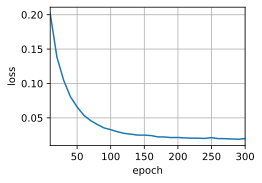

In [33]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## [**预测**]

为了采用一个接着一个词元的方式预测输出序列，
每个解码器当前时间步的输入都将来自于前一时间步的预测词元。
与训练类似，序列开始词元（“&lt;bos&gt;”）
在初始时间步被输入到解码器中。
该预测过程如 :numref:`fig_seq2seq_predict`所示，
当输出序列的预测遇到序列结束词元（“&lt;eos&gt;”）时，预测就结束了。

![使用循环神经网络编码器-解码器逐词元地预测输出序列。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/seq2seq-predict.svg?raw=1)
:label:`fig_seq2seq_predict`

我们将在 :numref:`sec_beam-search`中介绍不同的序列生成策略。


In [35]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    #src_sentence = "The Quick Brown Fox jumps over the lazy DOG."
    #['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog.']
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    #根据num_steps进行截断 使得每句话长度一样。
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps): #解码器是一个词一个词往外面蹦的
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2) #在最后一个维度vocab size选择概率所在的最大的索引
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        #squeeze是去掉batch size这个维度
        '''
        1. 模型输出 (Y): tensor([[[0.01, 0.02, ..., 0.9, ...]]])  # 形状: [1, 1, 10000]
        2. argmax(dim=2):    tensor([[25]])                       # 形状: [1, 1]
        3. squeeze(dim=0):   tensor([25])                         # 形状: [1]
        4. item():           25                                   # 类型: Python int
        '''
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [ ]:
# 在 init_state 方法内部可能发生的操作
def init_state(enc_outputs, enc_valid_lens):
    # 1. 存储编码器输出，用于后续注意力计算
    self.enc_outputs = enc_outputs

    # 2. 关键：利用 enc_valid_lens 生成注意力掩码！
    # 假设 max_len = enc_outputs 的长度
    self.attention_mask = (torch.arange(max_len, device=device)[None, :] < enc_valid_lens[:, None])
    # attention_mask 形状: (batch_size, max_len)
    # 有效位置为True，填充位置为False

    # 3. 初始化RNN的隐藏状态（通常直接使用编码器的最终隐藏状态）
    # ...
    return state

## 预测序列的评估

我们可以通过与真实的标签序列进行比较来评估预测序列。
虽然 :cite:`Papineni.Roukos.Ward.ea.2002`
提出的BLEU（bilingual evaluation understudy）
最先是用于评估机器翻译的结果，
但现在它已经被广泛用于测量许多应用的输出序列的质量。
原则上说，对于预测序列中的任意$n$元语法（n-grams），
BLEU的评估都是这个$n$元语法是否出现在标签序列中。

我们将BLEU定义为：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
第一个是预测序列与标签序列中匹配的$n$元语法的数量，
第二个是预测序列中$n$元语法的数量的比率。
具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$、$B$、$C$、$D$，
我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

根据 :eqref:`eq_bleu`中BLEU的定义，
当预测序列与标签序列完全相同时，BLEU为$1$。
此外，由于$n$元语法越长则匹配难度越大，
所以BLEU为更长的$n$元语法的精确度分配更大的权重。
具体来说，当$p_n$固定时，$p_n^{1/2^n}$
会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。
而且，由于预测的序列越短获得的$p_n$值越高，
所以 :eqref:`eq_bleu`中乘法项之前的系数用于惩罚较短的预测序列。
例如，当$k=2$时，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$，尽管$p_1 = p_2 = 1$，
惩罚因子$\exp(1-6/2) \approx 0.14$会降低BLEU。

[**BLEU的代码实现**]如下。


In [37]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利用训练好的循环神经网络“编码器－解码器”模型，
[**将几个英语句子翻译成法语**]，并计算BLEU的最终结果。


In [38]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va au lit !, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est riche perdu ., bleu 0.548
i'm home . => je suis ici ., bleu 0.512


## 小结

* 根据“编码器-解码器”架构的设计，
  我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
* 在实现编码器和解码器时，我们可以使用多层循环神经网络。
* 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
* 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。
* BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的$n$元语法的匹配度来评估预测。

## 练习

1. 试着通过调整超参数来改善翻译效果。
1. 重新运行实验并在计算损失时不使用遮蔽，可以观察到什么结果？为什么会有这个结果？
1. 如果编码器和解码器的层数或者隐藏单元数不同，那么如何初始化解码器的隐状态？
1. 在训练中，如果用前一时间步的预测输入到解码器来代替强制教学，对性能有何影响？
1. 用长短期记忆网络替换门控循环单元重新运行实验。
1. 有没有其他方法来设计解码器的输出层？


[Discussions](https://discuss.d2l.ai/t/2782)
